C:\Users\Airly\AppData\Local\Temp\ipykernel_16136\1471640987.py:60: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(method="time")


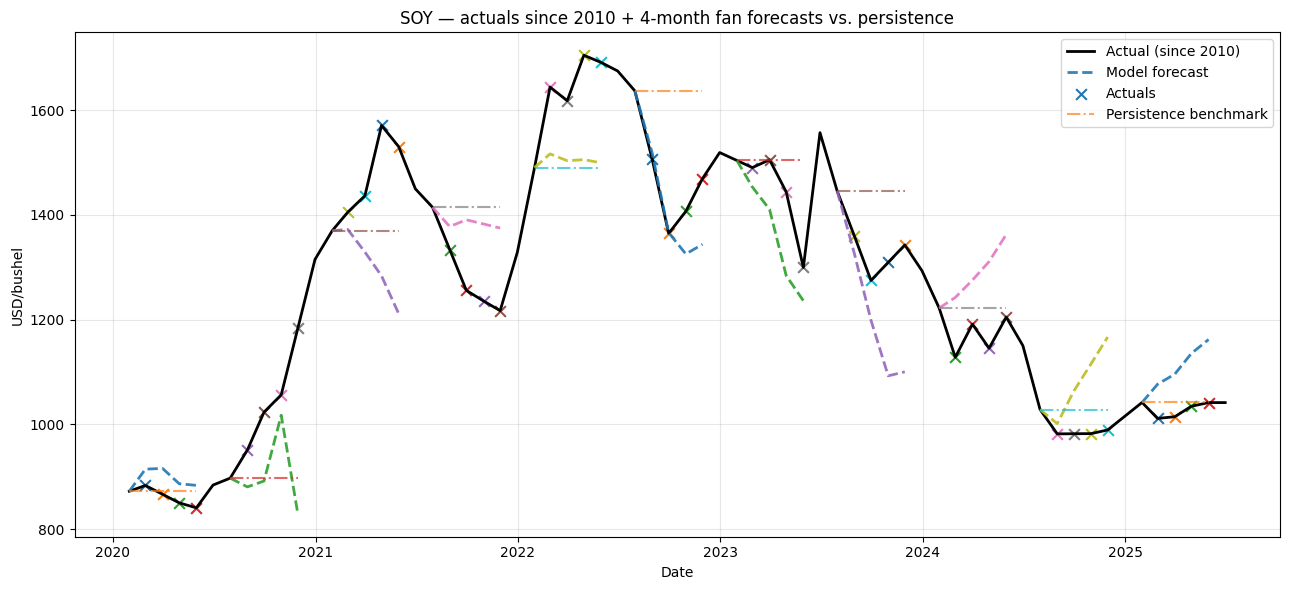


=== Porównanie R² i MAE (fan forecast: model vs persistence) ===
    N  R2_model  R2_persist  MAE_model  MAE_persist
h                                                  
1  11     0.934       0.898     53.438       66.756
2  11     0.830       0.706     87.053       93.978
3  11     0.600       0.676    142.439      121.091
4  11     0.288       0.563    177.543      128.023

Forecast-from-now anchor: 2025-06-30


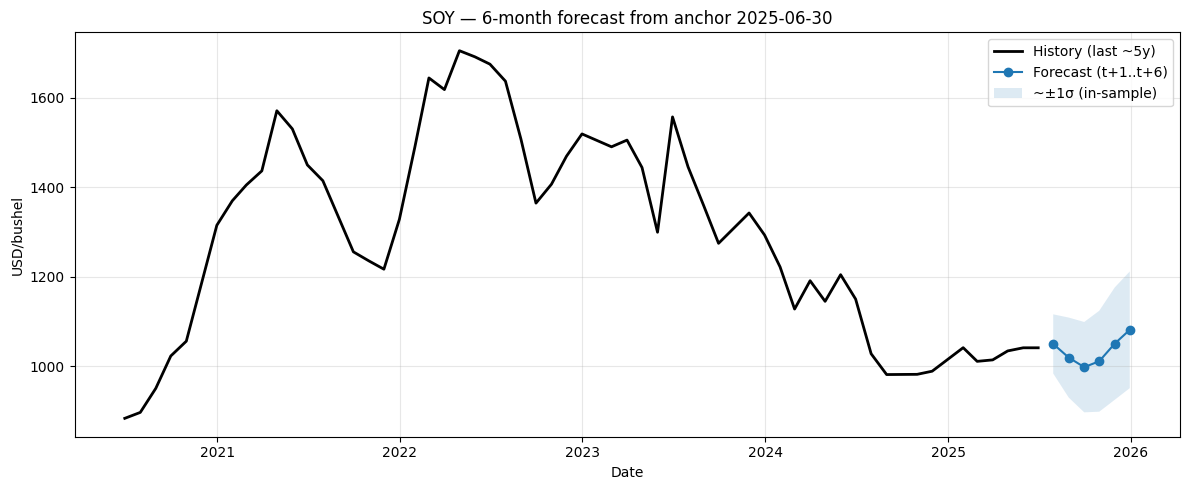


Forecasts from now (point, ±1σ if available):
  2025-07-30  (h=1):  1050.385 ± 66.084
  2025-08-30  (h=2):  1019.943 ± 89.319
  2025-09-30  (h=3):  998.541 ± 100.893
  2025-10-30  (h=4):  1011.735 ± 112.702
  2025-11-30  (h=5):  1051.080 ± 125.443
  2025-12-30  (h=6):  1081.888 ± 130.256


In [44]:
# %% SOY — ex-ante od 2010 (h=1..4), persistence benchmark, GridSearch MAE + forecast 6M "od teraz"
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score

# --------------------------- Parametry ---------------------------
IN_MERGED = os.path.join("data_out", "soyenso_merged.csv")
PLOT_START = pd.Timestamp("2020-01-01")   # od 2010, jak prosiłeś

# Ex-ante wachlarze: prognozujemy 4M naprzód
HORIZONS_EXANTE = [1, 2, 3, 4]

# Prognoza "od teraz": wykres do 6M naprzód
HORIZONS_FUTURE = [1, 2, 3, 4, 5, 6]

SOY_LAGS = list(range(0, 7))
EXOG_LAGS = list(range(0, 7))
ANCHOR_STEP_MONTHS = 6

# Zmienne egzogeniczne, które próbujemy wykorzystać (jeśli istnieją w csv)
WANTED_EXOG = [
    "ONI", "enso_proxy", "la_nina_index", "SWI_Brazil", "SWI_US",
    "FX_USDBRL", "FX_EURUSD", "WX_US", "WX_BR", "DXY",
    # możesz dodać więcej nazw kolumn – kod sam sprawdzi, czy są w danych
]

def winsorize_series(s: pd.Series, lower_q=0.005, upper_q=0.995):
    """
    Bezpieczna winsoryzacja: najpierw rzutujemy na numeric (errors='coerce'),
    liczymy quantyle na częściach numerycznych i przycinamy.
    Jeśli po konwersji nie ma danych numerycznych -> zwracamy oryginał.
    """
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.dropna().empty:
        return s  # nic do winsoryzacji (np. czysto tekstowa kolumna)

    lo, hi = s_num.quantile(lower_q), s_num.quantile(upper_q)
    s_num = s_num.clip(lo, hi)
    return s_num


def clean_column(series: pd.Series, is_price_like: bool = True) -> pd.Series:
    """
    Interpolacja czasowa -> bfill -> ffill -> winsoryzacja.
    Dla zmiennych 'price-like' zostawiamy wartości jak są; dla indeksów/klimatu też ok.
    """
    s = series.copy()
    # interpolacja po czasie + domknięcie luk
    if s.index.inferred_type in ("datetime64", "datetime64tz"):
        s = s.interpolate(method="time")
    else:
        s = s.interpolate()
    s = s.bfill().ffill()
    # winsoryzacja (ostrożnie; dla wskaźników klimatycznych nie szkodzi)
    s = winsorize_series(s, 0.005, 0.995)
    return s

def add_seasonality_month(df_idx: pd.DatetimeIndex) -> pd.DataFrame:
    """Cykliczna sezonowość miesiąca (sin/cos)."""
    m = df_idx.month
    return pd.DataFrame({
        "month_sin": np.sin(2 * np.pi * m / 12.0),
        "month_cos": np.cos(2 * np.pi * m / 12.0),
    }, index=df_idx)

def add_simple_tech_features(s: pd.Series) -> pd.DataFrame:
    """Proste cechy techniczne: 1M zwrot, 3M SMA, 3M zmienność."""
    df_feat = pd.DataFrame(index=s.index)
    df_feat["SOY_ret_1m"] = s.pct_change(1)
    df_feat["SOY_sma_3m"] = s.rolling(3).mean()
    df_feat["SOY_vol_3m"] = s.pct_change().rolling(3).std()
    # łatanie powstałych NaN
    for c in df_feat.columns:
        df_feat[c] = clean_column(df_feat[c], is_price_like=False)
    return df_feat

# --------------------------- Dane ---------------------------
df = pd.read_csv(IN_MERGED, parse_dates=["date"]).set_index("date").sort_index()
# indeks na koniec miesiąca
df.index = df.index.to_period("M").to_timestamp("M")

if "SOY" not in df.columns:
    raise ValueError("Brak kolumny 'SOY' w danych wejściowych.")

# Łatanie głównej serii
df["SOY"] = clean_column(df["SOY"], is_price_like=True)

# Opcjonalne: odrzuć bardzo „puste” kolumny (np. > 40% NaN przed czyszczeniem)
na_frac = df.isna().mean()
to_drop = na_frac[na_frac > 0.40].index.difference(["SOY"])  # SOY zostawiamy
if len(to_drop) > 0:
    df = df.drop(columns=list(to_drop))

# Po odrzuceniu kolumn: uzupełnij pozostałe kolumny egzogeniczne
for col in df.columns:
    if col != "SOY":
        df[col] = clean_column(df[col], is_price_like=False)

# Dodatkowe cechy: sezonowość i proste cechy techniczne
df_season = add_seasonality_month(df.index)
df_tech = add_simple_tech_features(df["SOY"])
df = pd.concat([df, df_season, df_tech], axis=1)

# ---------------------- Feature engineering ----------------------
# Lags SOY
for L in SOY_LAGS:
    df[f"SOY_lag{L}"] = df["SOY"].shift(L)

# Lags dla egzogenicznych (tylko dostępne)
exog_raw = [c for c in WANTED_EXOG if c in df.columns]
for c in exog_raw:
    for L in EXOG_LAGS:
        df[f"{c}_lag{L}"] = df[c].shift(L)

# Targety t+h (do 6, bo futurowy wykres jest do 6M)
for h in sorted(set(HORIZONS_EXANTE) | set(HORIZONS_FUTURE)):
    df[f"SOY_t+{h}"] = df["SOY"].shift(-h)

# Lista cech: lags SOY, lags exog, sezonowość i techniczne
feature_cols = (
    [c for c in df.columns if c.startswith("SOY_lag")] +
    [f"{c}_lag{L}" for c in exog_raw for L in EXOG_LAGS] +
    ["month_sin", "month_cos", "SOY_ret_1m", "SOY_sma_3m", "SOY_vol_3m"]
)

# Usuń cechy, których faktycznie nie ma (na wypadek braku exog)
feature_cols = [c for c in feature_cols if c in df.columns]

# ---------------------- Pipeline + GridSearchCV ----------------------
# Ridge + MAE (stabilniejszy przy wielu cechach)
pre = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]), feature_cols)
])

def make_model(gridsearch=True):
    pipe = Pipeline([("pre", pre), ("ridge", Ridge())])
    if not gridsearch:
        return pipe
    param_grid = {
        "ridge__alpha": [0.01, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0],
        "ridge__fit_intercept": [True, False]
    }
    cv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_mean_absolute_error",  # optymalizujemy MAE
        n_jobs=-1
    )
    return grid

# ---------------------- Ex-ante: wachlarze od 2010 ----------------------
plot_start = max(PLOT_START, df.index.min())
max_anchor_fans = df.index.max() - pd.DateOffset(months=max(HORIZONS_EXANTE))
candidates = df.index[(df.index >= plot_start) & (df.index <= max_anchor_fans)]
anchor_dates = list(candidates[::ANCHOR_STEP_MONTHS]) or ([candidates[-1]] if len(candidates) else [])

segments = []
residuals_by_h = {h: [] for h in HORIZONS_FUTURE}  # zbierzemy też dla 5–6 jeśli będzie potrzeba

for anchor in anchor_dates:
    per_h = {}
    for h in HORIZONS_EXANTE:
        y_col = f"SOY_t+{h}"
        df_h = df.dropna(subset=feature_cols + [y_col]).copy()

        # Zero look-ahead: do treningu <= anchor - h
        cutoff = anchor - pd.DateOffset(months=h)
        train = df_h.loc[:cutoff]
        if len(train) < 36:
            continue

        model = make_model(gridsearch=True)
        model.fit(train[feature_cols], train[y_col])

        # residuale treningowe dla sigma_h
        y_hat_tr = model.predict(train[feature_cols])
        residuals_by_h[h].extend((train[y_col].values - y_hat_tr).tolist())

        # predykcja w anchor
        if anchor not in df.index:
            continue
        X_anchor = df.loc[[anchor], feature_cols]
        y_hat = float(model.predict(X_anchor)[0])

        target_date = anchor + pd.DateOffset(months=h)
        y_act = float(df.loc[target_date, "SOY"]) if target_date in df.index else np.nan
        per_h[h] = {"target": target_date, "forecast": y_hat, "actual": y_act}

    if set(per_h.keys()) == set(HORIZONS_EXANTE):
        row = {"anchor": anchor, "p0": float(df.loc[anchor, "SOY"])}
        for h in HORIZONS_EXANTE:
            row[f"t{h}"] = per_h[h]["target"]
            row[f"f{h}"] = per_h[h]["forecast"]
            row[f"a{h}"] = per_h[h]["actual"]
        segments.append(row)

seg_df = pd.DataFrame(segments).sort_values("anchor") if segments else pd.DataFrame()

# ---------------------- Wykres: wachlarze ex-ante (model vs persistence) ----------------------
if not df.empty and not seg_df.empty:
    plt.figure(figsize=(13, 6))
    hist = df["SOY"].loc[plot_start: df.index.max()]
    plt.plot(hist.index, hist.values, color="black", linewidth=2, label="Actual (since 2010)")

    for i, row in seg_df.iterrows():
        xs = [row["anchor"]] + [row[f"t{h}"] for h in HORIZONS_EXANTE]
        ys_model = [row["p0"]] + [row[f"f{h}"] for h in HORIZONS_EXANTE]
        # Model
        plt.plot(xs, ys_model, linestyle="--", linewidth=2, alpha=0.9,
                 label="Model forecast" if i == 0 else "")
        # Rzeczywiste punkty
        for h in HORIZONS_EXANTE:
            t_key, a_key = f"t{h}", f"a{h}"
            if pd.notna(row[a_key]):
                plt.scatter([row[t_key]], [row[a_key]], marker="x", s=60,
                            label="Actuals" if i == 0 and h == HORIZONS_EXANTE[0] else "")
        # Benchmark: persistence (płaska linia od anchor)
        plt.plot(xs, [row["p0"]] * len(xs), linestyle="-.", alpha=0.7,
                 label="Persistence benchmark" if i == 0 else "")

    plt.title("SOY — actuals since 2010 + 4-month fan forecasts vs. persistence")
    plt.xlabel("Date"); plt.ylabel("USD/bushel")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------------------- Tabelka: MAE i R² (model vs persistence) ----------------------
def mae(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.nanmean(np.abs(a - b)))

results = []
if not seg_df.empty:
    for h in HORIZONS_EXANTE:
        f_col, a_col = f"f{h}", f"a{h}"
        if f_col not in seg_df or a_col not in seg_df:
            continue
        mask = seg_df[f_col].notna() & seg_df[a_col].notna()
        if mask.sum() < 3:
            continue

        y_true = seg_df.loc[mask, a_col].values
        y_model = seg_df.loc[mask, f_col].values
        y_persist = seg_df.loc[mask, "p0"].values

        results.append({
            "h": h,
            "N": int(mask.sum()),
            "R2_model": r2_score(y_true, y_model),
            "R2_persist": r2_score(y_true, y_persist),
            "MAE_model": mae(y_true, y_model),
            "MAE_persist": mae(y_true, y_persist),
        })

results_df = pd.DataFrame(results).set_index("h") if results else pd.DataFrame()
if not results_df.empty:
    print("\n=== Porównanie R² i MAE (fan forecast: model vs persistence) ===")
    print(results_df.round(3))

# ---------------------- Prognoza „od teraz” na 6 miesięcy ----------------------
def last_complete_month(ts: pd.Timestamp) -> pd.Timestamp:
    first_of_month = ts.replace(day=1)
    return (first_of_month - pd.offsets.Day(1)).normalize()

today = pd.Timestamp.today().normalize()
anchor_now = min(last_complete_month(today), df.index.max())
if anchor_now not in df.index:
    anchor_now = df.index.max()

print(f"\nForecast-from-now anchor: {anchor_now.date()}")

# Oszacowanie sigma_h (std residuali in-sample). Jeśli dla h=5..6 brakuje z ex-ante, policzmy ad-hoc:
sigma_by_h = {}
for h in HORIZONS_FUTURE:
    res = residuals_by_h.get(h, [])
    if len(res) == 0:
        # estymacja na całej historii do anchor_now-h
        y_col = f"SOY_t+{h}"
        df_h = df.dropna(subset=feature_cols + [y_col]).copy()
        cutoff = anchor_now - pd.DateOffset(months=h)
        train = df_h.loc[:cutoff]
        if len(train) >= 36:
            model_tmp = make_model(gridsearch=True)
            model_tmp.fit(train[feature_cols], train[y_col])
            y_hat_tr = model_tmp.predict(train[feature_cols])
            res = (train[y_col].values - y_hat_tr).tolist()
    sigma_by_h[h] = (float(np.std(res, ddof=0)) if len(res) > 0 else np.nan)

# Właściwe prognozy na 6M do przodu
future_forecasts = []
for h in HORIZONS_FUTURE:
    y_col = f"SOY_t+{h}"
    df_h = df.dropna(subset=feature_cols + [y_col]).copy()
    cutoff = anchor_now - pd.DateOffset(months=h)
    train = df_h.loc[:cutoff]
    if len(train) < 36:
        print(f"Skipping h={h}: not enough training data up to {cutoff.date()}")
        continue

    model = make_model(gridsearch=True)
    model.fit(train[feature_cols], train[y_col])

    X_anchor = df.loc[[anchor_now], feature_cols]
    f_hat = float(model.predict(X_anchor)[0])

    target_date = anchor_now + pd.DateOffset(months=h)
    future_forecasts.append({"h": h, "target": target_date, "forecast": f_hat})

# Wykres prognozy „od teraz” na 6M
if future_forecasts:
    fut_df = pd.DataFrame(future_forecasts).sort_values("h")
    plt.figure(figsize=(12, 5))

    hist_start = max(df.index.min(), anchor_now - relativedelta(years=5))
    hist = df["SOY"].loc[hist_start: anchor_now]
    plt.plot(hist.index, hist.values, color="black", linewidth=2, label="History (last ~5y)")

    plt.plot(fut_df["target"], fut_df["forecast"], linestyle="-", marker="o", label="Forecast (t+1..t+6)")

    up = []; lo = []
    for _, r in fut_df.iterrows():
        sigma = sigma_by_h.get(int(r["h"]), np.nan)
        up.append(r["forecast"] + (sigma if np.isfinite(sigma) else 0.0))
        lo.append(r["forecast"] - (sigma if np.isfinite(sigma) else 0.0))
    if len(up) == len(lo) == len(fut_df):
        plt.fill_between(fut_df["target"].values, lo, up, alpha=0.15, label="~±1σ (in-sample)")

    plt.title(f"SOY — 6-month forecast from anchor {anchor_now.date()}")
    plt.xlabel("Date"); plt.ylabel("USD/bushel")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nForecasts from now (point, ±1σ if available):")
    for _, r in fut_df.iterrows():
        h = int(r["h"])
        sigma = sigma_by_h.get(h, np.nan)
        if np.isfinite(sigma):
            print(f"  {r['target'].date()}  (h={h}):  {r['forecast']:.3f} ± {sigma:.3f}")
        else:
            print(f"  {r['target'].date()}  (h={h}):  {r['forecast']:.3f}")
else:
    print("No future forecasts produced (insufficient data around the latest anchor).")


Co jeszcze warto dodać jako zmienne (jeśli masz dane)

Podaż/popyt (USDA/CONAB/IGO):

Zapasy końcowe i stocks-to-use (USA/świat), produkcja, area harvested, plony (USA, Brazylia, Argentyna).

WASDE miesięczne rewizje (dummy „surprise” i/lub różnica vs konsensus).


Pogoda/uprawy:

Opady/temperatura anomalia (USA Midwest, Brasil/Matopiba) – miesięczne i 3M rolling.

SM/soil moisture, SWI (masz) + NDVI (wegetacja), GPP.

Faza ENSO (ONI/MEI), indeksy MJO, IOD – masz część (ONI, la_nina, enso_proxy).


Rynki i kursy:

FX BRL/USD (masz), DXY (masz), CNY (popyt z Chin).

WTI/Brent (biodiesel, oleje roślinne), Palm Oil (ceny zamienne), Corn/Wheat (substytuty).

Frachts: Baltic Dry/Grain freight (wpływ na ceny CIF/FOB).


Popyt i przetwórstwo:

COT (Commitments of Traders) – net positions Money Managers dla Soy (sentiment).

Crush margin / soy oil / soy meal spreads (relacje przetwórcze).

Ekspor t-y/w (US Export Inspections), chiński import (GACC), PMI China.


Struktura rynku:

Term structure: różnica front vs next futures (contango/backwardation).

Zmienność: 1M/3M vol z futures/returns (częściowo dodałem 3M vol).

Efekty kalendarzowe:

Dodatkowe dummies (np. miesiąc raportu WASDE, okres sadzenia/zbiorów).